# Лабораторная работа №2 "Проведение исследований с логистической и линейной регрессией"

## Подключение вспомогательных библиотек

In [1]:
from itertools import combinations
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.metrics
import sklearn.model_selection
import sklearn.linear_model
import sklearn.preprocessing
import sklearn.feature_selection

import imblearn.under_sampling

## Классификация

### 2. Создание бейзлайна и оценка качества

#### Подготовка бейзлайна

Перед началом обучения модели сформируем бейзлайн, подобно тому, как это было выполнено в рамках лабораторной работы №1

In [4]:
!kaggle datasets download -q -p dataset -d saurabhbadole/bank-customer-churn-prediction-dataset
!unzip dataset/bank-customer-churn-prediction-dataset.zip -d dataset/

ds = pd.read_csv("dataset/Churn_Modelling.csv")
ds.head()

baseline_ds = ds.drop(columns=["RowNumber", "CustomerId", "Surname"])

baseline_ds = pd.get_dummies(baseline_ds, columns=["Geography"], dtype=int)
baseline_ds = pd.get_dummies(baseline_ds, columns=["Gender"], dtype=int)

baseline_ds.head()

Dataset URL: https://www.kaggle.com/datasets/saurabhbadole/bank-customer-churn-prediction-dataset
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
Archive:  dataset/bank-customer-churn-prediction-dataset.zip
  inflating: dataset/Churn_Modelling.csv  


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


#### Обучение модели

Перейдем теперь к этапу обучения модели. По аналогии с лабораторной работой №1, для этого создадим вспомогательные функции:

- `generate_train_data` - отвечает за то, чтобы сгенерировать набор данных для тестирования и обучения на основе переданного датасета

- `get_model_metrics` - отвечает за рассчет показаний метрик для уже обученной модели на основе тестовых данных

- `print_model_metrics` - отвечает за отформатированный вывод показаний метрик

In [3]:
def generate_train_data(dataset, *, target_feature="Exited", random_state=42, test_size=0.2):
  X = dataset.drop(columns=[target_feature])
  y = dataset[target_feature]

  X_train, X_test, y_train, y_test = map(
    np.array,
    sklearn.model_selection.train_test_split(
      X, y,
      test_size=test_size,
      random_state=random_state,
    ),
  )

  return (X_train, y_train), (X_test, y_test)


def get_model_metrics(model, X_test, y_test):
  y_pred = model.predict(X_test)

  accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
  precision = sklearn.metrics.precision_score(y_test, y_pred)
  recall = sklearn.metrics.recall_score(y_test, y_pred)
  f1 = sklearn.metrics.f1_score(y_test, y_pred)

  confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)

  return {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "confusion_matrix": confusion_matrix,
  }

def print_model_metrics(model, X_test, y_test):
  metrics = get_model_metrics(model, X_test, y_test)

  print(f"Accuracy: {metrics['accuracy']:.4f}")
  print(f"Precision: {metrics['precision']:.4f}")
  print(f"Recall: {metrics['recall']:.4f}")
  print(f"F1-Score: {metrics['f1']:.4f}")

  print("\nConfusion Matrix:")
  print(metrics["confusion_matrix"])


Обучим теперь модель логистической регрессии для решения задачи классификации на бейзлайн-датасете, который мы ранее определили и выведем на экран показатели метрик для итоговой обученной модели.

In [ ]:
(X_train, y_train), (X_test, y_test) = generate_train_data(baseline_ds)

model = sklearn.linear_model.LogisticRegression()
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Accuracy: 0.8000
Precision: 0.4521
Recall: 0.0840
F1-Score: 0.1416

Confusion Matrix:
[[1567   40]
 [ 360   33]]


На основе полученных показаний метрик можно сделать следующие выводы.

Во-первых модель имеет высокие показатели "Accuracy", однако из-за несбалансированности данных в датасете эта метрика не слишком информативна.

Низкие значения метрик "Precision", "Recall" и "F1-Score" указывают на то, что модель плохо справляется с задачей классификации уходящих клиентов.

Итого, предлагается при дальнейшем улучшении бейзлайна придерживаться идеи того, чтобы увеличить значение метрики "F1-Score", чтобы модель могла хорошо работать с несбалансированными данными.

### 3. Улучшение бейзлайна

#### Учитывание несбалансированности класса

Как было отмечено выше, ключевой проблемой низких значений метрики "F1-Score" является несбалансированность данных. Однако, среди гиперпараметров для логической регресии есть параметр `class_weight`, который предназначен для работы с несбалансированными классами.

In [ ]:
(X_train, y_train), (X_test, y_test) = generate_train_data(baseline_ds)

model = sklearn.linear_model.LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Accuracy: 0.6495
Precision: 0.3250
Recall: 0.7277
F1-Score: 0.4493

Confusion Matrix:
[[1013  594]
 [ 107  286]]


Как видим, итоговое значение метрики "F1-Score" возросло в разы, что говорит нам о том, что гипотеза была верна. Однако, с другой стороны упало значение для метрики "Accuracy", что обосновывается тем, что модель теперь делает больший упор на класс, соответствующих уходящим клиентам.

#### Масштабирование данных

Так как алгоритм логической регрессии в процессе обучения использует методы оптимизации для минимизации функции потерь, такие как градиентный спуск, то в случае, когда значения признаков находятся в разных масштабах, шаги спуска могут быть неоптимальными.

Из этого следует, что признаки с большими значениями могут доминировать в вычислениях градиента, замедляя тем самым процесс сходимости.

Данная проблема может быть решена путем приведения значений к единому числовому диапазону.

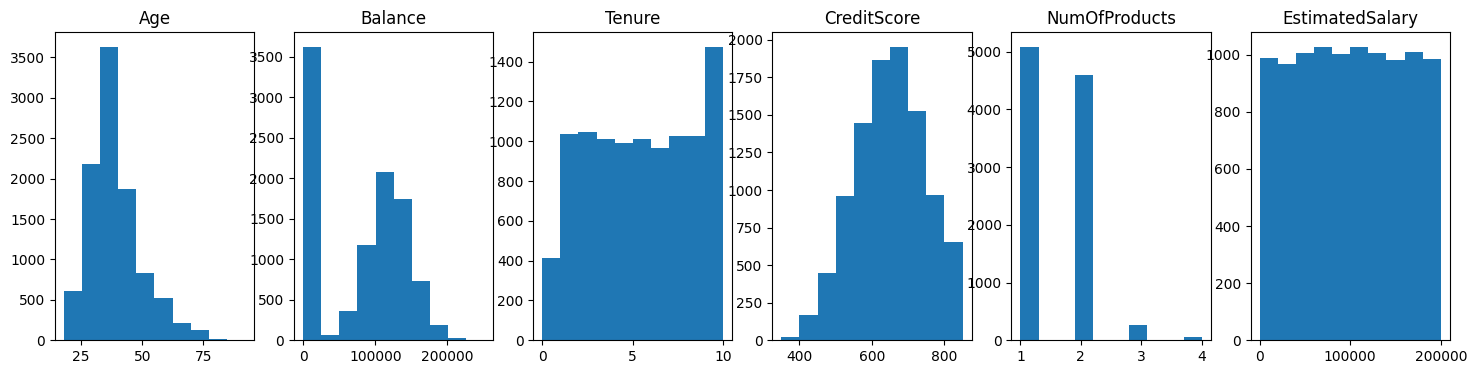

In [4]:
numerical_features = ["Age", "Balance", "Tenure", "CreditScore", "NumOfProducts", "EstimatedSalary"]
n = len(numerical_features)

def print_histograms(dataset):
  plt.figure(figsize=(18, 4))

  for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, n, i)
    plt.hist(dataset[feature])
    plt.title(feature)

  plt.show()

print_histograms(baseline_ds)

Как видим, диапазоны значений для признаков сильно различаются. Попробуем решить найденную проблему путем нормализации значений, тем самым приведя диапазоны значений к единому.

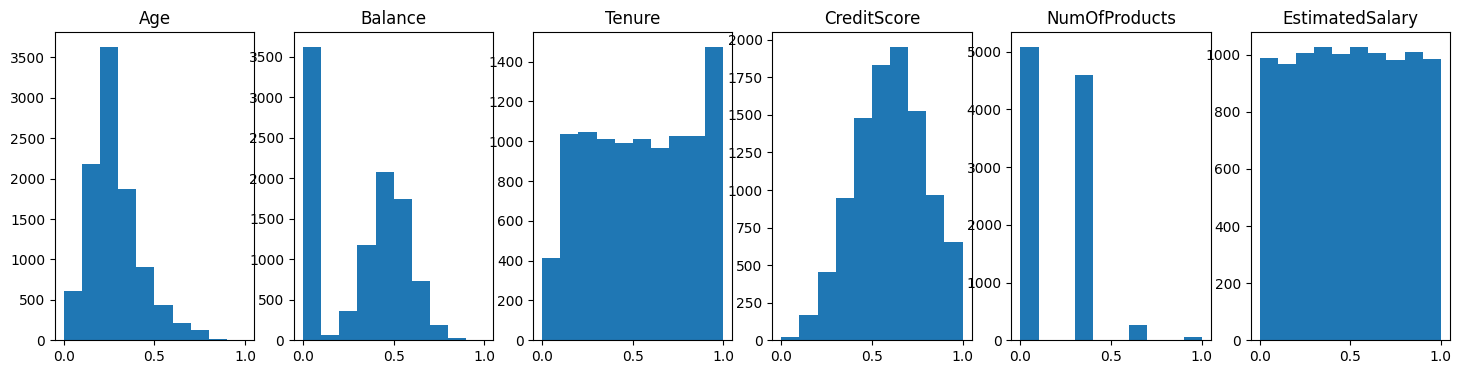

In [5]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaled_ds = baseline_ds.copy()
scaled_ds[numerical_features] = scaler.fit_transform(scaled_ds[numerical_features])

print_histograms(scaled_ds)

Проверим, улучшились ли показатели метрик после произведенных улучшений бейзлайна

In [ ]:
(X_train, y_train), (X_test, y_test) = generate_train_data(scaled_ds)

model = sklearn.linear_model.LogisticRegression(class_weight="balanced")
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Accuracy: 0.7180
Precision: 0.3830
Recall: 0.7125
F1-Score: 0.4982

Confusion Matrix:
[[1156  451]
 [ 113  280]]


Как видим, нормализация значения привела хоть и к незначительным, но улучшениям показателей метрик, что говорит нам о том, что гипотеза была верна.

#### Удаление лишних признаков

Лишние признаки являются частой проблемой, характерной для датасетов в контексте обучения линейных моделей, так как они добавляют шум в данные. Такие признаки с одной стороны не содержат полезной информации о целевой переменной, но с другой могут способствовать переобучению модели, ухудшению ее сходимости и т. д.

Поэтому, имеет смысл убрать признаки, которые меньше всего влияют на итоговые предсказания. Используя свойство линейности моделей, мы можем определить, какие признаки наиболее значимы, ссылаясь на их веса.

Итого, задача сводится к нахождению признаков с маленькими значениями весов и их последующему удалению.

In [ ]:
threshold = 0.1
dropped_features = []

columns = list(scaled_ds.columns)
columns.remove("Exited")

x = list(zip(columns, np.abs(model.coef_[0])))
x.sort(key=lambda p: p[1], reverse=True)

for col, coef in x:
  print(col, coef)
  if coef < threshold:
    dropped_features.append(col)

print()
print("Features to remove:")
for feature in dropped_features:
  print(f"- {feature}")

Age 5.498346330423403
IsActiveMember 0.9088602383595306
Balance 0.6739127323222789
Gender_Male 0.5796947039823491
Geography_France 0.4980380083209078
Geography_Spain 0.3872946437896131
CreditScore 0.35541699865425475
NumOfProducts 0.27486108248184243
Geography_Germany 0.2745882024105238
Tenure 0.13555457966668616
EstimatedSalary 0.05698878938611727
HasCrCard 0.03544325380876052
Gender_Female 0.031049745717761038

Features to remove:
- EstimatedSalary
- HasCrCard
- Gender_Female


Проверим, улучшились ли показатели метрик после произведенных улучшений бейзлайна

In [ ]:
scaled_ds_2 = scaled_ds.drop(columns=dropped_features)

(X_train, y_train), (X_test, y_test) = generate_train_data(scaled_ds_2)

model = sklearn.linear_model.LogisticRegression(class_weight="balanced")
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Accuracy: 0.7180
Precision: 0.3827
Recall: 0.7099
F1-Score: 0.4993

Confusion Matrix:
[[1157  450]
 [ 114  279]]


Как видно, удаление лишних признаков привело к небольшому приросту показаний для метрики "F1-Score". Гипотеза оказалась верной, но не слишком эффективной.

#### Feature engineering

Одной из частых практик по улучшению бейзлайна конкретно для линейных моделей является feature engineering, заключающийся в генерации новых признаков на основе уже существующих.

При этом генерация новых признаков происходит за счет использования нелинейных признаков. Тем самым мы даем модели больше информации, которую она бы не смогла получить через линейные преобразования.

Для проверки данной гипотезы реализуем вспомогательную функцию `extend_dataset`, которая будет создавать на основе входного датасета новый, содержащий дополнительные признаки, полученные путем перемноженяи переданных.

In [ ]:
def extend_dataset(dataset, columns):
  extended_ds = dataset.copy()
  col_a, col_b = columns

  poly = sklearn.preprocessing.PolynomialFeatures(
    degree=2,
    interaction_only=False,
    include_bias=False,
  )

  poly_ds = pd.DataFrame(
    poly.fit_transform(extended_ds[[col_a, col_b]]),
    columns=[col_a, col_b, f'{col_a}^2', f'{col_a}_{col_b}', f'{col_b}^2'],
  )

  return pd.concat(
    [extended_ds, poly_ds.drop(columns=[col_a, col_b])],
    axis=1,
  )


Также, реализуем еще одну вспомогательную функцию `find_best_columns_pair`, которая из всех возможных пар признаков найдет ту, которая даст наилучшее значение метрики при обучении модели.

In [ ]:
def find_best_columns_pair(dataset, target_feature="Exited"):
  columns = set(dataset.columns)
  columns.remove(target_feature)

  combs = set(combinations(columns, 2))
  results = []

  for cols in tqdm(combs):
    extended_ds = extend_dataset(dataset, cols)
    (X_train, y_train), (X_test, y_test) = generate_train_data(extended_ds)

    model = sklearn.linear_model.LogisticRegression(class_weight="balanced")
    model.fit(X_train, y_train)
    metrics = get_model_metrics(model, X_test, y_test)

    results.append({
      "columns": cols,
      "accuracy": metrics["accuracy"],
      "f1": metrics["f1"],
    })

  results.sort(
    key=lambda p: (p["accuracy"], p["f1"]),
    reverse=True,
  )

  return pd.DataFrame({
    key: [ el[key] for el in results ]
    for key in results[0].keys()
  })

Попробуем найти наилучшую пару признаков для последнего оптимизированного бейзлайна

In [ ]:
find_best_columns_pair(scaled_ds_2)

100%|██████████| 45/45 [00:04<00:00,  9.06it/s]


,columns,accuracy,f1
0,"(NumOfProducts, Balance)",0.7720,0.571429
1,"(Tenure, NumOfProducts)",0.7685,0.566885
2,"(IsActiveMember, NumOfProducts)",0.7680,0.568773
3,"(Age, NumOfProducts)",0.7680,0.564728
4,"(Geography_France, NumOfProducts)",0.7675,0.568245
5,"(Geography_Spain, NumOfProducts)",0.7670,0.566108
6,"(Gender_Male, NumOfProducts)",0.7670,0.564486
7,"(Geography_Germany, NumOfProducts)",0.7650,0.560748
8,"(CreditScore, NumOfProducts)",0.7595,0.554217
9,"(Age, IsActiveMember)",0.7335,0.507849


Как видим, наилучшей парой оказалась `NumOfProducts`, `Balance`. Попробуем обучить модель на расширенном датасете и сравнить значения метрик с прошлыми.

In [ ]:
extended_ds = extend_dataset(scaled_ds_2, ("NumOfProducts", "Balance"))

(X_train, y_train), (X_test, y_test) = generate_train_data(extended_ds)

model = sklearn.linear_model.LogisticRegression(class_weight="balanced")
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Accuracy: 0.7720
Precision: 0.4531
Recall: 0.7735
F1-Score: 0.5714

Confusion Matrix:
[[1240  367]
 [  89  304]]


Как видим, добавление новых признаков дало значительный прирост в качестве полученной модели! А следовательно, гипотеза оказалась верной и крайне эффективной.

Попробуем найти еще одну пару признаков, которые бы могли дать больше информации модели

In [ ]:
find_best_columns_pair(extended_ds)

100%|██████████| 78/78 [00:07<00:00, 10.99it/s]


,columns,accuracy,f1
0,"(Age, IsActiveMember)",0.7820,0.579151
1,"(Geography_France, NumOfProducts_Balance)",0.7770,0.578450
2,"(Geography_France, NumOfProducts)",0.7750,0.576271
3,"(NumOfProducts^2, Geography_Germany)",0.7750,0.576271
4,"(NumOfProducts_Balance, NumOfProducts)",0.7745,0.574929
...,...,...,...
73,"(CreditScore, NumOfProducts)",0.7670,0.566108
74,"(Age, Geography_Spain)",0.7665,0.566388
75,"(Age, NumOfProducts^2)",0.7660,0.565056
76,"(Age, NumOfProducts_Balance)",0.7655,0.566142


В этот раз лучшей парой оказались признаки `Age`, `IsActiveMember`. Попробуем обучить модель на расширенном датасете и сравнить значения метрик с прошлыми.

In [ ]:
extended_ds_2 = extend_dataset(extended_ds, ("Age", "IsActiveMember"))

(X_train, y_train), (X_test, y_test) = generate_train_data(extended_ds_2)

model = sklearn.linear_model.LogisticRegression(class_weight="balanced")
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Accuracy: 0.7820
Precision: 0.4666
Recall: 0.7634
F1-Score: 0.5792

Confusion Matrix:
[[1264  343]
 [  93  300]]


Как видим, добавление новых признаков снова дало прирост в качестве полученной модели!

### 4. Имплементация алгоритма машинного обучения

Перейдем теперь к собственной имплементации алгоритма логистической регрессии для решения задачи классификации. Решение я реализовал в виде класса `MyLogisticRegression`, который имеет интерфейс, схожий с тем, что используется в библиотеке `sklearn`. присутствуют 2 метода: `fit` - для обучения модели, `predict` - для предсказания классов для уже обученной модели.

Сам алгоритм градиентного спуска я решил реализовать в виде отдельной функции, которая отвечает за поиск такого набора значений параметров, при котором целевая функция будет принимать минимальные значения.

In [ ]:
sigmoid = lambda x: 1.0 / (1.0 + np.exp(-x))


def gradient_descent(df, initial, learn_rate, iterations):
  x = initial
  for _ in range(iterations):
    dx = df(x)
    x -= dx * learn_rate
  return x


class MyLogisticRegression:
  def __init__(self, *, learn_rate=0.01, epochs=1_000):
    self.__learn_rate = learn_rate
    self.__epochs = epochs

    self.__weights = None
    self.__bias = None
    self.__X = None
    self.__y = None

  def __loss_gradient(self, x):
    assert self.__X is not None
    assert self.__y is not None

    n, _ = self.__X.shape
    weights, bias = x[:-1], x[-1]
    y_predicted = sigmoid(np.dot(self.__X, weights) + bias)

    d_weights = np.dot(self.__X.T, (y_predicted - self.__y)) / n
    d_bias = np.sum(y_predicted - self.__y) / n

    return np.array([*d_weights, d_bias])

  def fit(self, X, y):
    assert self.__weights is None
    assert self.__bias is None

    self.__X = np.array(X)
    self.__y = np.array(y)
    _, m = self.__X.shape

    # Начальные веса
    x0 = gradient_descent(
      self.__loss_gradient,
      2.0 * np.ones(m + 1),
      self.__learn_rate,
      self.__epochs,
    )

    self.__weights = x0[:-1]
    self.__bias = x0[-1]

    def predict(self, X):
      assert self.__weights is not None
      assert self.__bias is not None

      y_predicted = sigmoid(np.dot(X, self.__weights) + self.__bias)
      return np.array([i >= 0.5 for i in y_predicted], dtype=int)

#### Сравнение с бейзлайном

Обучим теперь реализованную модель на датасете, соответствущем бейзлайну. Из-за определенных ранее вспомогательных функций и схожего интерфейса класса модели основной алгоритм обучения не меняется.

In [ ]:
(X_train, y_train), (X_test, y_test) = generate_train_data(baseline_ds)

model = MyLogisticRegression()
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Accuracy: 0.1995
Precision: 0.1968
Recall: 0.9975
F1-Score: 0.3287

Confusion Matrix:
[[   7 1600]
 [   1  392]]


Сравним полученные результаты для имплементированной модели с результатами из пункта 2.

Как видно, показатели метрик значительно отличаются от тех, что были получены при обучении модели из пункта 2. В этот раз модель отдала предпочтение классу уходящих клиентов, из-за чего значение метрики "F1-Score" оказалось выше в 2 раза, однако, значение метрики "Accuracy" в разы упало.

Одной из причин такого расхождения может послужить недостаточно обширный набор гиперпараметров для модели и различия в реализации метода оптимизации.

#### Сравнение с улучшенным бейзлайном

In [ ]:
(X_train, y_train), (X_test, y_test) = generate_train_data(extended_ds_2)

model = MyLogisticRegression()
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Accuracy: 0.7930
Precision: 0.4356
Recall: 0.1807
F1-Score: 0.2554

Confusion Matrix:
[[1515   92]
 [ 322   71]]


Как видим, при обучении на улучшенном бейзлайне ситуация начинает меняться. Реализованная модель стала работать более ожидаемо - она отдает предпочтение более частому классу, из-за чего значение метрики "Accuracy" значительно возрасло.

С другой стороны, значение метрики "F1-Score" стало значительно меньше, чем у модели из пункта 3. Возможными причинами является отсутствие гиперпараметра `class_weight`, без которого реализованная модель также не учитывает несбалансированность классов.

## Регрессия

### 2. Создание бейзлайна и оценка качества

#### Подготовка бейзлайна

Перед началом обучения модели сформируем бейзлайн, подобно тому, как это было выполнено в рамках лабораторной работы №1

In [6]:
!kaggle datasets download -q -p dataset -d denkuznetz/taxi-price-prediction
!unzip dataset/taxi-price-prediction.zip -d dataset/

Dataset URL: https://www.kaggle.com/datasets/denkuznetz/taxi-price-prediction
License(s): apache-2.0
Archive:  dataset/taxi-price-prediction.zip
  inflating: dataset/taxi_trip_pricing.csv  


In [ ]:
ds = pd.read_csv("/content/dataset/taxi_trip_pricing.csv")
baseline_ds = ds.dropna(subset=["Trip_Price"])

numeric_features = [
  "Trip_Distance_km",
  "Passenger_Count",
  "Base_Fare",
  "Per_Km_Rate",
  "Per_Minute_Rate",
  "Trip_Duration_Minutes",
]
baseline_ds[numeric_features] = baseline_ds[numeric_features].apply(lambda col: col.fillna(col.median()))

categorical_features = [
  "Time_of_Day",
  "Day_of_Week",
  "Traffic_Conditions",
  "Weather",
]

for feature in categorical_features:
  encoded_feature = pd.get_dummies(baseline_ds[feature], prefix=feature, dtype=int)
  baseline_ds[encoded_feature.columns] = encoded_feature
  baseline_ds = baseline_ds.drop(columns=[feature])

baseline_ds.head()

,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price,Time_of_Day_Afternoon,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Day_of_Week_Weekday,Day_of_Week_Weekend,Traffic_Conditions_High,Traffic_Conditions_Low,Traffic_Conditions_Medium,Weather_Clear,Weather_Rain,Weather_Snow
0,19.35,3.0,3.56,0.80,0.32,53.82,36.2624,0,0,1,0,1,0,0,1,0,1,0,0
2,36.87,1.0,2.70,1.21,0.15,37.27,52.9032,0,1,0,0,0,1,1,0,0,1,0,0
3,30.33,4.0,3.48,0.51,0.15,116.81,36.4698,0,1,0,0,1,0,0,1,0,0,0,0
4,25.87,3.0,2.93,0.63,0.32,22.64,15.6180,0,1,0,0,1,0,1,0,0,1,0,0
5,8.64,2.0,2.55,1.71,0.48,89.33,60.2028,1,0,0,0,0,1,0,0,1,1,0,0


#### Обучение модели

Перейдем теперь к этапу обучения модели. По аналогии с лабораторной работой №1, для этого создадим вспомогательные функции:

- `generate_train_data` - отвечает за то, чтобы сгенерировать набор данных для тестирования и обучения на основе переданного датасета

- `get_model_metrics` - отвечает за рассчет показаний метрик для уже обученной модели на основе тестовых данных

- `print_model_metrics` - отвечает за отформатированный вывод показаний метрик

In [ ]:
def generate_train_data(dataset, *, target_feature="Trip_Price", test_size=0.2, random_state=42):
  X = dataset.drop(columns=[target_feature])
  y = dataset[target_feature]
  X_train, X_test, y_train, y_test = map(
    np.array,
    sklearn.model_selection.train_test_split(
      X, y,
      test_size=test_size,
      random_state=random_state,
    ),
  )

  return (X_train, y_train), (X_test, y_test)


def get_model_metrics(model, X_test, y_test):
  y_pred = model.predict(X_test)

  mae = sklearn.metrics.mean_absolute_error(y_test, y_pred)
  r2 = sklearn.metrics.r2_score(y_test, y_pred)

  return { "mae": mae, "r2": r2 }


def print_model_metrics(model, X_test, y_test):
  results = get_model_metrics(model, X_test, y_test)

  print(f"Mean Absolute Error (MAE): {results['mae']:.4f}")
  print(f"R-squared (R2): {results['r2']:.4f}")

Обучим теперь модель линейной регрессии для решения задачи регрессии на бейзлайн-датасете, который мы ранее определили и выведем на экран показатели метрик для итоговой обученной модели.

In [ ]:
(X_train, y_train), (X_test, y_test) = generate_train_data(baseline_ds)

model = sklearn.linear_model.LinearRegression()
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Mean Absolute Error (MAE): 9.9619
R-squared (R2): 0.8763


На основе полученных показателей метрик можно сделать следующие выводы.

В среднем модель ошибается на 10 денежных единиц, что значительно лучше по сравнению с KNN алгоритмом, однако все также остается проблема для дешевых поездок, так как для них эта погрешность существенна.

А также, модель хорошо улавливает зависимости внутри данных, что можно заметить по высоким значениям метрики `R2`.


### 3. Улучшение бейзлайна

#### Избавление от мультиколлинеарности

Подобно тому, как было реализовано в лабораторной работе №1, улучшение бейзлайна начнем с решения проблемы мультиколлинеарности.

Мультиколлинеарность для линейной регрессии может оказать негативное влияние, так как может спровоцировать нестабильность оценок коэффициентов.

При высокой мультиколлинеарности признаки сильно коррелируют между собой.
Это приводит к тому, что модель не может однозначно определить влияние каждого признака на целевую переменную.

Для проверки наличия мультиколлинеарности построим матрицу корреляции.

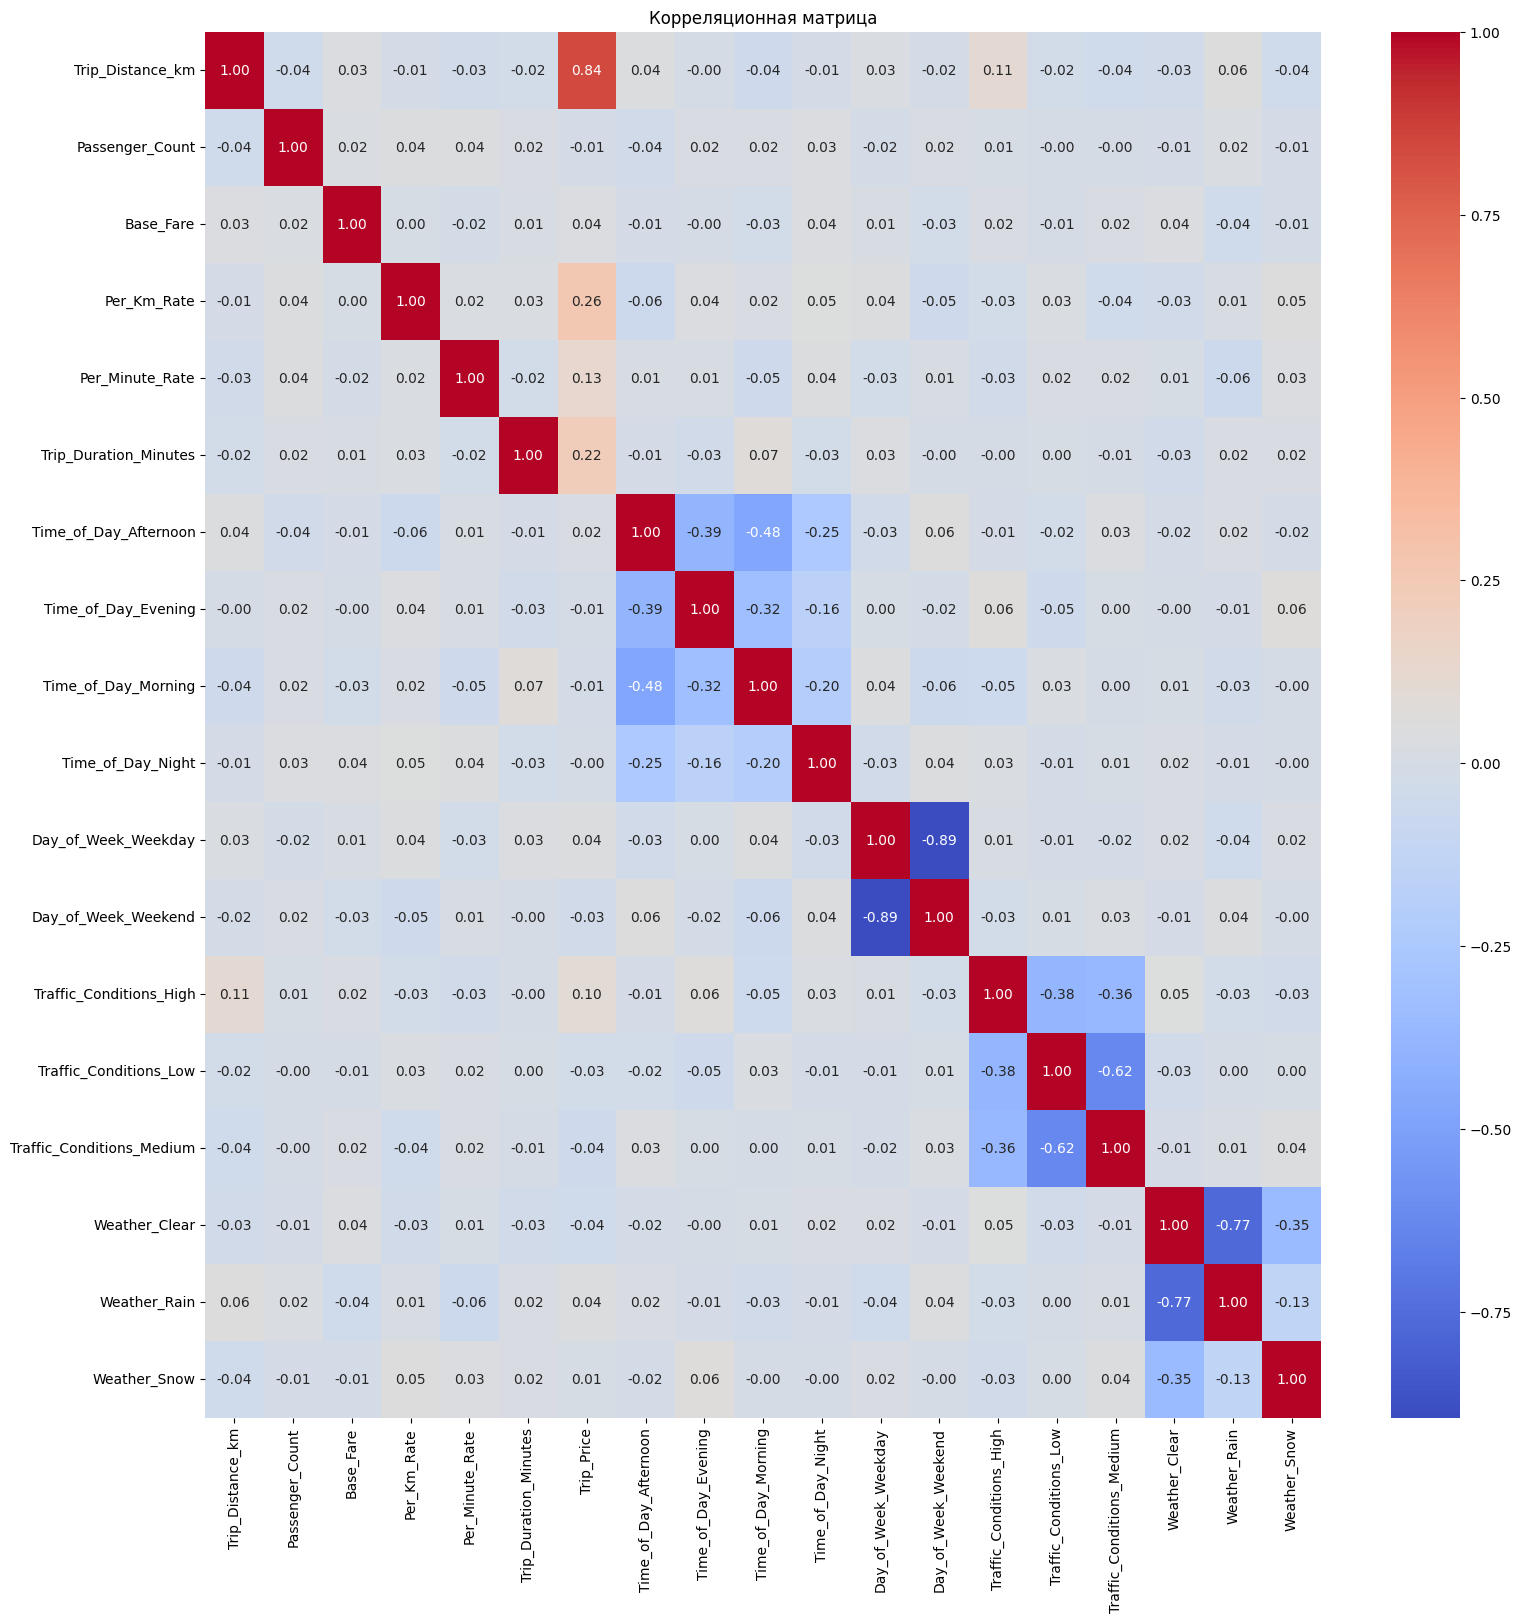

In [8]:
corr_matrix = baseline_ds.corr().drop("Trip_Price", axis=0)

plt.figure(figsize=(18, 18))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляционная матрица")
plt.show()

Как видим, проблема мультиколлинеарности свойственна для категориальных признаков, таких как "Тип дня недели", "Время суток", "Условия трафика", "Погода".

Решим найденную проблему путем сведения признаков, которые были созданы через one-hot encoding к одному признаку с использованием порядкого кодирования.

In [48]:
def convert_one_hot_to_single_column(dataset, new_column, one_hot_columns):
  dataset[new_column] = sum(w * dataset[col] for w, col in enumerate(one_hot_columns, 1))
  dataset.drop(columns=one_hot_columns, inplace=True)


optimized_ds = baseline_ds.copy()

convert_one_hot_to_single_column(
  dataset=optimized_ds,
  new_column="Day_of_Week",
  one_hot_columns=["Day_of_Week_Weekday", "Day_of_Week_Weekend"],
)

convert_one_hot_to_single_column(
  dataset=optimized_ds,
  new_column="Time_of_Day",
  one_hot_columns=["Time_of_Day_Morning", "Time_of_Day_Afternoon", "Time_of_Day_Evening", "Time_of_Day_Night"],
)

convert_one_hot_to_single_column(
  dataset=optimized_ds,
  new_column="Traffic_Conditions",
  one_hot_columns=["Traffic_Conditions_Low", "Traffic_Conditions_Medium", "Traffic_Conditions_High"],
)

convert_one_hot_to_single_column(
  dataset=optimized_ds,
  new_column="Weather",
  one_hot_columns=["Weather_Clear", "Weather_Rain", "Weather_Snow"],
)

optimized_ds.head()

,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price,Day_of_Week,Time_of_Day,Traffic_Conditions,Weather
0,19.35,3.0,3.56,0.80,0.32,53.82,36.2624,1,1,1,1
2,36.87,1.0,2.70,1.21,0.15,37.27,52.9032,2,3,3,1
3,30.33,4.0,3.48,0.51,0.15,116.81,36.4698,1,3,1,0
4,25.87,3.0,2.93,0.63,0.32,22.64,15.6180,1,3,3,1
5,8.64,2.0,2.55,1.71,0.48,89.33,60.2028,2,2,2,1


Проверим, улучшились ли показатели метрик после произведенных улучшений бейзлайна

In [ ]:
(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds)

model = sklearn.linear_model.LinearRegression()
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Mean Absolute Error (MAE): 9.8686
R-squared (R2): 0.8773


Как видим, хоть и незначительно, но значение метрики `MAE` уменьшилось, а следовательно гипотеза была верна!

#### Избавление от выбросов

Также, частой проблемй являются выбросы данных, особенно для линейных моделей, так как такие значения сильно выходят за рамки основного распределения, что может негативно сказаться на процессе обучения модели, помешав методу оптимизации найти оптимальный набор весов.

Возьмем за целевой признак `Trip_Distance_km`, выбросы в котором мы будем удалять. Для визуального анализа на наличие выбросов отобразим 3 графика:

- Ящик с усами, который визуально демонстрирует основные параметры распределения
- Гистограмму, описывающую распределение значений
- График `Trip Distance vs Trip Price`, чтобы рассмотреть, как целевая переменная заивсит от значений признака

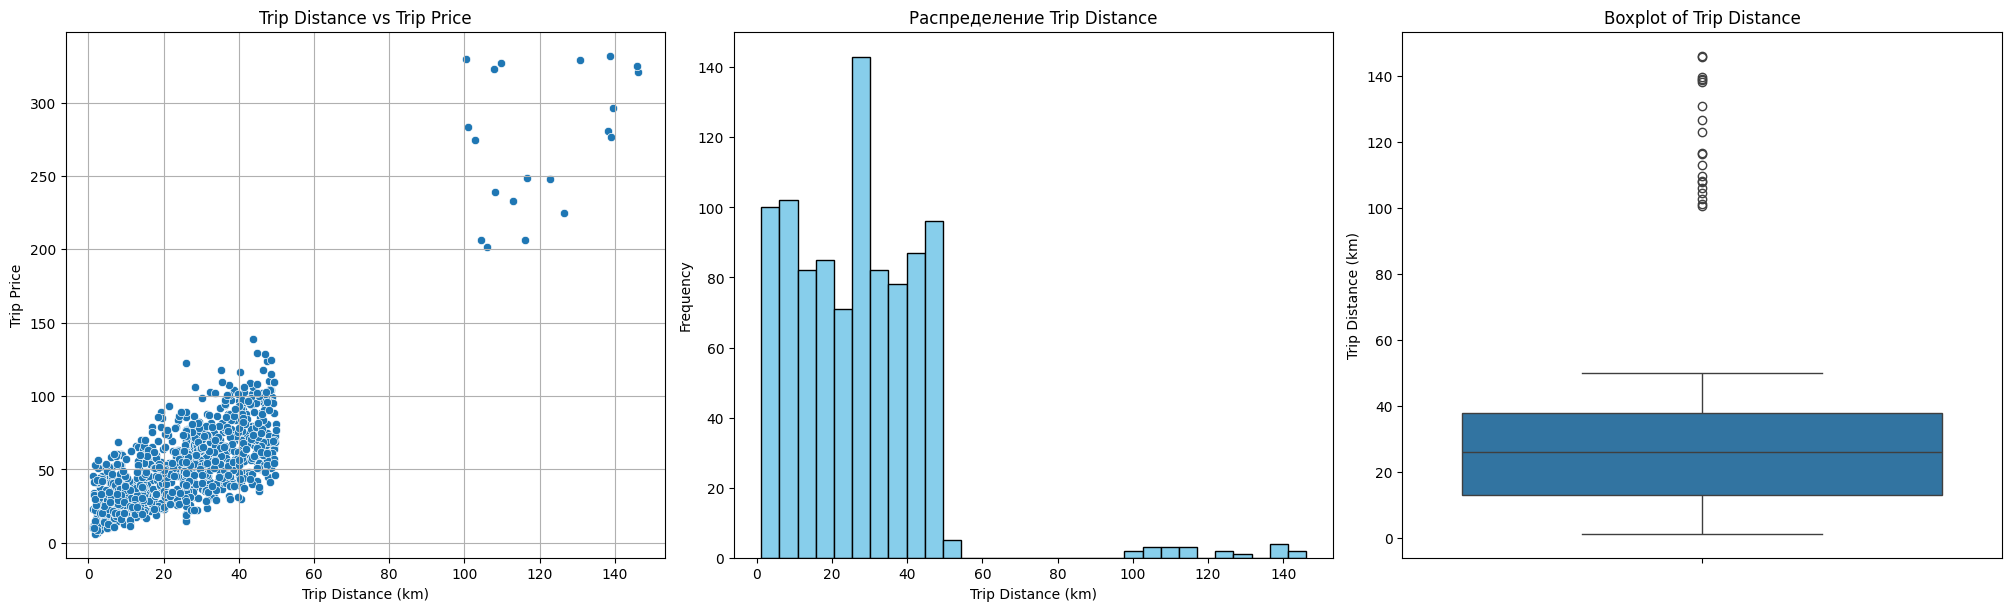

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), constrained_layout=True)

sns.scatterplot(
    x="Trip_Distance_km",
    y="Trip_Price",
    data=optimized_ds,
    ax=axes[0]
)
axes[0].set_title("Trip Distance vs Trip Price")
axes[0].set_xlabel("Trip Distance (km)")
axes[0].set_ylabel("Trip Price")
axes[0].grid(True)

axes[1].hist(optimized_ds["Trip_Distance_km"], bins=30, color="skyblue", edgecolor="black")
axes[1].set_title("Распределение Trip Distance")
axes[1].set_xlabel("Trip Distance (km)")
axes[1].set_ylabel("Frequency")

sns.boxplot(
    y="Trip_Distance_km",
    data=optimized_ds,
    ax=axes[2]
)
axes[2].set_title("Boxplot of Trip Distance")
axes[2].set_ylabel("Trip Distance (km)")

plt.show()

И так, судя по гистограмме, мы видим, что основная часть находится в диапазоне `[0; 50]` километров, а также есть длинный "хвост", который указывает на наличие выбросов.

Наличие выбросов также подтверждает ящик с усами. Также, стоит отметить, что основная часть данных сосредоточена в интерквартильном диапазоне.

Судя по последнему графику, видна связь между `Trip_Distance_km` и `Trip_Price`: с увеличением расстояния цена растет. А следовательно, данный признак влияет на итоговые предсказания.


In [ ]:
Q1 = optimized_ds["Trip_Distance_km"].quantile(0.25)
Q3 = optimized_ds["Trip_Distance_km"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

optimized_ds_2 = optimized_ds[(lower_bound <= optimized_ds["Trip_Distance_km"]) & (optimized_ds["Trip_Distance_km"] <= upper_bound)]
optimized_ds_2.head()

,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price,Day_of_Week,Time_of_Day,Traffic_Conditions,Weather
0,19.35,3.0,3.56,0.80,0.32,53.82,36.2624,1,1,1,1
2,36.87,1.0,2.70,1.21,0.15,37.27,52.9032,2,3,3,1
3,30.33,4.0,3.48,0.51,0.15,116.81,36.4698,1,3,1,0
4,25.87,3.0,2.93,0.63,0.32,22.64,15.6180,1,3,3,1
5,8.64,2.0,2.55,1.71,0.48,89.33,60.2028,2,2,2,1


Проверим, улучшились ли показатели метрик после произведенных улучшений бейзлайна

In [ ]:
(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds_2)

model = sklearn.linear_model.LinearRegression()
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Mean Absolute Error (MAE): 6.5536
R-squared (R2): 0.8847


Как видим, избавление от выбросов дало значительные улучшения! А следовательно гипотеза была верна!

#### Feature engineering

Как было видно при решении задачи регрессии, применение feature engineering при улучшении бейзлайна может оказать значительный прирост в качестве модели. Попробуем провести аналогичные действия для задачи регрессии.

Однако, в этот раз попробуем подобрать пару признаков не методом подбора, а логически. Можно заметить, что датасет содержит такие признаки, как `Trip_Distance_km` и `Per_Km_Rate`, которые соответствуют длине поездки в километрах и стоимости поездки на километр.

Логичным было бы добавление признака, описывающего возможную цену поездки на основе этих двух параметров.

In [ ]:
optimized_ds_3 = optimized_ds_2.copy()

optimized_ds_3["Per_Km_Rate__Trip_Distance_km"] = optimized_ds_3["Trip_Distance_km"] * optimized_ds_3["Per_Km_Rate"]
optimized_ds_3 = optimized_ds_3.drop(columns=["Trip_Distance_km", "Per_Km_Rate"])

optimized_ds_3.head()

,Passenger_Count,Base_Fare,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price,Day_of_Week,Time_of_Day,Traffic_Conditions,Weather,Per_Km_Rate__Trip_Distance_km
0,3.0,3.56,0.32,53.82,36.2624,1,1,1,1,15.4800
2,1.0,2.70,0.15,37.27,52.9032,2,3,3,1,44.6127
3,4.0,3.48,0.15,116.81,36.4698,1,3,1,0,15.4683
4,3.0,2.93,0.32,22.64,15.6180,1,3,3,1,16.2981
5,2.0,2.55,0.48,89.33,60.2028,2,2,2,1,14.7744


Проверим, улучшились ли показатели метрик после произведенных улучшений бейзлайна

In [ ]:
(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds_3)

model = sklearn.linear_model.LinearRegression()
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Mean Absolute Error (MAE): 3.8405
R-squared (R2): 0.9482


Как видим, добавление нового признака дало значительные улучшения! А следовательно гипотеза была верна!

Попробуем провести аналогичные действия на основе тех же предположений для признаков `Trip_Duration_Minutes` и `Per_Minute_Rate`

In [ ]:
optimized_ds_4 = optimized_ds_3.copy()

optimized_ds_4["Per_Minute_Rate__Trip_Duration_Minutes"] = optimized_ds_4["Trip_Duration_Minutes"] * optimized_ds_4["Per_Minute_Rate"]
optimized_ds_4 = optimized_ds_4.drop(columns=["Trip_Duration_Minutes", "Per_Minute_Rate"])

optimized_ds_4.head()

,Passenger_Count,Base_Fare,Trip_Price,Day_of_Week,Time_of_Day,Traffic_Conditions,Weather,Per_Km_Rate__Trip_Distance_km,Per_Minute_Rate__Trip_Duration_Minutes
0,3.0,3.56,36.2624,1,1,1,1,15.4800,17.2224
2,1.0,2.70,52.9032,2,3,3,1,44.6127,5.5905
3,4.0,3.48,36.4698,1,3,1,0,15.4683,17.5215
4,3.0,2.93,15.6180,1,3,3,1,16.2981,7.2448
5,2.0,2.55,60.2028,2,2,2,1,14.7744,42.8784


In [ ]:
(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds_4)

model = sklearn.linear_model.LinearRegression()
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Mean Absolute Error (MAE): 1.7641
R-squared (R2): 0.9704


Как видно, добавление еще одного нового признака еще сильнее улучшело качество итоговой модели.

### 4. Имплементация алгоритма машинного обучения

Перейдем теперь к собственной имплементации алгоритма линейной регрессии для решения задачи регрессии. Решение я реализовал в виде класса `MyLinearRegression`, который имеет интерфейс, схожий с тем, что используется в библиотеке `sklearn`. присутствуют 2 метода: `fit` - для обучения модели, `predict` - для предсказания классов для уже обученной модели.

В отличие от реализации логической регрессии, здесь я не использовал итеративные методы оптимизации в силу того, что целевая функция, которую необходимо минимизировать, имеет довольно простую структуру. А следовательно, можно воспользоваться другими методами, такими как методом Гаусса для решения СЛАУ.

In [ ]:
class MyLinearRegression:
  def __init__(self):
    self.__weights = None

  def __extend_x(self, X):
    n = X.shape[0]
    return np.append(np.ones((n, 1)), X, axis=1)

  def fit(self, X_train, y_train):
    extended_x = self.__extend_x(X_train)
    A = extended_x.T @ extended_x
    b = extended_x.T @ y_train
    self.__weights = np.linalg.solve(A, b)

  def predict(self, X_test):
    return self.__extend_x(X_test) @ self.__weights

#### Сравнение с бейзлайном

Обучим теперь реализованную модель на датасете, соответствущем бейзлайну. Из-за определенных ранее вспомогательных функций и схожего интерфейса класса модели основной алгоритм обучения не меняется.

In [ ]:
(X_train, y_train), (X_test, y_test) = generate_train_data(baseline_ds)

model = MyLinearRegression()
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Mean Absolute Error (MAE): 9.9619
R-squared (R2): 0.8763


Как видим, итоговые показатели метрик практически не отличаются по сравнению с теми, что были у модели из пункта 2, что говорит нам о схожести применяемых идей при реализации моделей.

In [ ]:
(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds_4)

model = MyLinearRegression()
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Mean Absolute Error (MAE): 1.7641
R-squared (R2): 0.9704


Аналогичная ситуация и при улучшенном бейзлайне: итоговые показатели метрик практически не отличаются от тех, что были у модели из пункта 3